# Summer Data Scientist Data Assessment
## Crime and Education Lab New York
*Jesica Maria Ramirez Toscano*

### Part 1: Variable Creation

In [164]:
import pandas as pd
import numpy as np
arrests = pd.read_csv('arrests.csv')
demo = pd.read_csv('demo.csv')
demo['bdate'] = pd.to_datetime(demo['bdate'], utc=False)
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], utc=False)

1. We filter the arrest to the ones that occurred post-implementation.  
2. Since we need information about past arrests and potential felony re-arrests, we merge the post-arrests with the total arrests by person_id. So each arrest will be linked to a post-arrest of the same individual.
> Note: **arrest_post** refers to the data of arrests post-implementation.  **tr** refers to the merged data of arrests_post with all the arrests. So each arrest in this data set is linked to a post-arrest of the same individual.

In [168]:
arrests_post = arrests[arrests['arrest_date'] >= '2010-01-01'].copy()
tr = pd.merge(arrests,
              arrests_post.rename(columns={'arrest_date':'date_post', 
                                            'arrest_id':'aid_post', 
                                            'law_code':'code_post'}), 
              on='person_id')

3. We create different tables to obtain the number of prior misdemeanor arrests and felony arrests in the last 2 years and 6 months.

In [169]:
twoyear = tr[(tr['arrest_date'] >= tr['date_post']-pd.DateOffset(years=2)) & (tr['arrest_id'] != tr['aid_post'])]
sixmonth = tr[(tr['arrest_date'] >= tr['date_post'] - pd.DateOffset(months=6)) & (tr['arrest_id'] != tr['aid_post'])]
twoyear =  twoyear.groupby(['aid_post', 'law_code']).size().unstack().reset_index().fillna(0)
twoyear.rename(columns = {'aid_post':'arrest_id', 'felony': 'fel_2y', 'misdemeanor': 'mis_2y'}, inplace=True)
sixmonth = sixmonth.groupby(['aid_post', 'law_code']).size().unstack().reset_index().fillna(0)
sixmonth.rename(columns = {'aid_post':'arrest_id', 'felony': 'fel_6m', 'misdemeanor': 'mis_6m'}, inplace=True)

>So for the table **twoyear**, we have the post_arrests variable with the number of prior felony and misdemeanor arrests in the last two years.

In [172]:
twoyear

law_code,arrest_id,fel_2y,mis_2y
0,000192be,0.0,1.0
1,000316a6,1.0,3.0
2,0005e711,1.0,3.0
3,000fca1a,1.0,3.0
4,00102ecf,0.0,3.0
...,...,...,...
19068,fff23454,1.0,4.0
19069,fff2c58f,0.0,3.0
19070,fff4f37a,1.0,0.0
19071,fff50975,1.0,0.0


4. To create the felony re-arrest binary variable, we need information about the potential future felony arrest of that individual. So first, we create a table called **year_ahead** using the **tr** dataset.

In [173]:
year_ahead = tr[(tr['arrest_date'] >= tr['date_post']) & (tr['arrest_id'] != tr['aid_post'])]
year_ahead = year_ahead[year_ahead['arrest_date'] <= year_ahead['date_post'] + pd.DateOffset(years=1)]
year_ahead = year_ahead.groupby(['aid_post', 'law_code']).size().unstack().reset_index().fillna(0)
year_ahead.rename(columns = {'aid_post':'arrest_id', 'felony': 'felony_arrests' }, inplace=True)

In [174]:
year_ahead[['arrest_id', 'felony_arrests']]

law_code,arrest_id,felony_arrests
0,000192be,0.0
1,000fca1a,0.0
2,00102ecf,0.0
3,001a4d40,0.0
4,002183f7,0.0
...,...,...
8975,ffd580fe,0.0
8976,ffe20b13,1.0
8977,fff23454,0.0
8978,fff2c58f,0.0


>With this table, we can create a binary variable of re_arrest (1 if the individual has one or more felony arrests during one year following the arrest, 0 if the individual has no felony re-arrest)

In [176]:
year_ahead['re_arrest'] = np.where(year_ahead['felony_arrests'] > 0,1,0)

5. With twoyear, sixmonth, year_ahead tables, we can now fill the data in arrests_post about the number of prior felony arrests and misdemeanor arrests in the last 2 years and 6 months, and the binary variable re_arrest (felony re-arrest).

In [177]:
arrests_post = arrests_post.merge(twoyear, on='arrest_id', how='left').fillna(0)
arrests_post = arrests_post.merge(sixmonth, on='arrest_id', how='left').fillna(0)
arrests_post = arrests_post.merge(year_ahead[['arrest_id', 're_arrest']], on='arrest_id', how='left').fillna(0)

In [178]:
arrests_post

,person_id,arrest_date,arrest_id,law_code,fel_2y,mis_2y,fel_6m,mis_6m,re_arrest
0,14,2010-01-01,e6a8cdb3,felony,1.0,0.0,1.0,0.0,1.0
1,350,2010-01-01,be6e57e3,misdemeanor,1.0,5.0,0.0,3.0,0.0
2,1409,2010-01-01,8af55340,misdemeanor,0.0,2.0,0.0,1.0,0.0
3,2850,2010-01-01,cbb41c9a,misdemeanor,1.0,2.0,0.0,2.0,0.0
4,2945,2010-01-01,65c81707,misdemeanor,2.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
21514,16253,2011-12-31,93ad5fb5,felony,1.0,1.0,1.0,0.0,0.0
21515,16287,2011-12-31,fee2d3a2,misdemeanor,0.0,2.0,0.0,1.0,0.0
21516,17822,2011-12-31,e94fc5a0,misdemeanor,0.0,0.0,0.0,0.0,0.0
21517,18044,2011-12-31,86e5491e,felony,0.0,0.0,0.0,0.0,0.0


6. Finally, we include data about the home precinct, age, and gender of the individual in each arrest.
>For the age variable, we obtain the difference in the arrest date and the birthdate (the result is in days, we convert it to years.)  
For the gender variable, we noticed it has four unique values: M, F, male, female. So we changed male and female values as M and F.

In [179]:
final = pd.merge(arrests_post, demo, on='person_id')
final['age'] = ((final['arrest_date'] - final['bdate']) / np.timedelta64(1, 'Y')).round().astype(int)
final.drop(['bdate', 'arrest_id',], axis=1, inplace=True)

In [180]:
final.gender.unique()

array(['M', 'F', 'male', 'female'], dtype=object)

In [181]:
final.loc[final['gender'] == 'male', 'gender'] = 'M'
final.loc[final['gender'] == 'female', 'gender'] = 'F'

In [182]:
print(final.gender.unique())
final

['M' 'F']


,person_id,arrest_date,law_code,fel_2y,mis_2y,fel_6m,mis_6m,re_arrest,gender,home_precinct,age
0,14,2010-01-01,felony,1.0,0.0,1.0,0.0,1.0,M,58,21
1,14,2010-09-28,felony,1.0,0.0,0.0,0.0,0.0,M,58,22
2,350,2010-01-01,misdemeanor,1.0,5.0,0.0,3.0,0.0,M,38,42
3,350,2010-08-23,misdemeanor,0.0,5.0,0.0,0.0,0.0,M,38,42
4,1409,2010-01-01,misdemeanor,0.0,2.0,0.0,1.0,0.0,M,61,20
...,...,...,...,...,...,...,...,...,...,...,...
21514,13443,2011-12-31,misdemeanor,0.0,0.0,0.0,0.0,0.0,M,12,23
21515,14245,2011-12-31,misdemeanor,0.0,0.0,0.0,0.0,0.0,F,1,21
21516,17822,2011-12-31,misdemeanor,0.0,0.0,0.0,0.0,0.0,M,66,18
21517,18044,2011-12-31,felony,0.0,0.0,0.0,0.0,0.0,M,66,40


### Part 2: Statistical Analysis >> Program Evaluation

In [183]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.discrete.discrete_model import Probit

1. First, we import data about the treatment and control precincts
2. Then, we are only interested in measuring the effect of the program for the first time an individual receives treatment, we filter the data to the first arrest of each individual in the post-implementation period. 

In [184]:
treat = pd.read_csv('treatment_assignment.csv')
treat.rename(columns={'precinct' : 'home_precinct'}, inplace=True)

first = final.groupby('person_id').agg({'arrest_date':min}).reset_index()
first =  first.merge(final, on=['person_id', 'arrest_date'])

 > If we look at the data in the treatment_assignment data set, there are 30 precincts (control and treatment precincts), whereas in the data set of first arrests post-implementation period, there are 77 different precincts.

In [185]:
print('Treatment-control precincts: {}'.format(len(treat.home_precinct.unique())))
print('Arrests post-implementation precincts: {}'.format(len(first.home_precinct.unique())))

Treatment-control precincts: 30
Arrests post-implementation precincts: 77


>In this sense, we have two options:  
a) Assume that the precincts not included in the treatment_assignment data set are also CONTROL.  
b) Assume that the treatment_assignment is complete and those precincts were chosen to study because they are similar to each other. 

I'm going to follow the option b), and drop the observations that don't fall in the control and treatment precincts.

In [186]:
data_eval = first.merge(treat, on=['home_precinct'], how='right')
data_eval.drop(['person_id', 'arrest_date'], axis=1, inplace=True)
data_eval

,law_code,fel_2y,mis_2y,fel_6m,mis_6m,re_arrest,gender,home_precinct,age,treatment_status
0,misdemeanor,1.0,0.0,0.0,0.0,0.0,F,73,25,control
1,misdemeanor,1.0,1.0,0.0,1.0,0.0,M,73,31,control
2,felony,0.0,1.0,0.0,0.0,0.0,M,73,27,control
3,misdemeanor,1.0,3.0,1.0,3.0,1.0,M,73,31,control
4,misdemeanor,0.0,4.0,0.0,0.0,0.0,F,73,36,control
...,...,...,...,...,...,...,...,...,...,...
3660,felony,1.0,2.0,0.0,1.0,0.0,M,74,31,treatment
3661,misdemeanor,1.0,1.0,1.0,1.0,1.0,M,74,19,treatment
3662,felony,0.0,1.0,0.0,0.0,0.0,M,74,24,treatment
3663,misdemeanor,0.0,2.0,0.0,2.0,0.0,M,74,29,treatment


3. Before evaluating the success of the program, we change the values of the following variables:  
-gender  to 1 for Men and 0 for Female  
-treatment_status to 1 for treatment and 0 for control  
-law_code to 1 for felony and 0 for misdemeanor

In [187]:
data_eval['gender'] = np.where(data_eval['gender']== 'M', 1, 0)
data_eval['treatment_status'] = np.where(data_eval['treatment_status']== 'control', 0, 1)
data_eval['law_code'] = np.where(data_eval['law_code']== 'felony', 1, 0)

4. To analyze the effectiveness of this program, we regress the re_arrest variable on the rest of the covariates.
> Since the dependent variable is binary, we must estimate heteroscedasticity robust standard errors

In [193]:
IND_VARS = ['treatment_status', 'age', 'gender', 'law_code', 'fel_2y', 'mis_2y', 'fel_6m', 'mis_6m']
all_ = sm.add_constant(data_eval[IND_VARS])
model1 = sm.OLS(data_eval['re_arrest'], all_).fit(cov_type='HC1')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              re_arrest   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     131.7
Date:                Thu, 26 Mar 2020   Prob (F-statistic):          9.18e-195
Time:                        22:50:14   Log-Likelihood:                 340.69
No. Observations:                3665   AIC:                            -663.4
Df Residuals:                    3656   BIC:                            -607.5
Df Model:                           8                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0136      0.017      0.800      0.424      -0.020       0.047
treatment_status     0.0035      0.007      0.474      0.635      -0.011       0.018
age                  0.0003      0.001      0.570      0.568      -0.001       0.002
gender              -0.0005      0.009     -0.061      0.952      -0.018       0.017
law_code            -0.0082      0.008     -1.066      0.286      -0.023       0.007
fel_2y               0.0129      0.008      1.625      0.104      -0.003       0.028
mis_2y              -0.0054      0.005     -1.131      0.258      -0.015       0.004
fel_6m               0.5299      0.019     27.738      0.000       0.492       0.567
mis_6m              -0.0056      0.007     -0.803      0.422      -0.019       0.008
==============================================================================
Omnibus:                      630.272   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3726.130
Skew:                          -0.684   Prob(JB):                         0.00
Kurtosis:                       7.746   Cond. No.                         145.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

*In this linear probability model, we observe that the treatment_status is not statistically significant, which may imply that there is no evidence to say that the program reduced or even affected the probability of felony re-arrest. In fact, the only variable that signifincantly explains the variation in the re_arrest probability is the recent-history (prior 6 months) of felony arrests. We plot this variable (prior felony arrests in the last 6 months) with the binary variable re_arrest and the estimated probability values of this model. In the graph above, we observe that the some estimated values are above one, and below zero (which makes no sense in probability).*

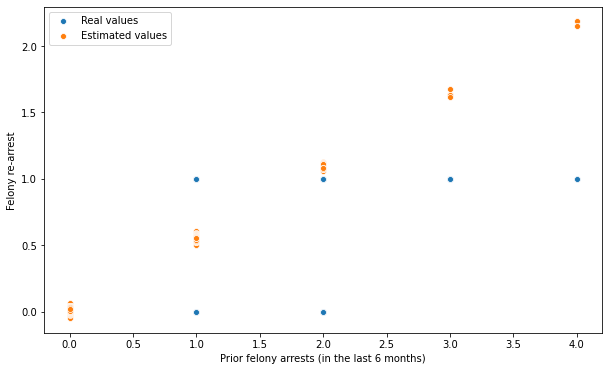

In [194]:
plt.figure(figsize=(10,6))
sns.scatterplot(data_eval['fel_6m'],data_eval['re_arrest'], label='Real values')
sns.scatterplot(data_eval['fel_6m'],model1.fittedvalues, label='Estimated values')
plt.xlabel("Prior felony arrests (in the last 6 months)")
plt.ylabel("Felony re-arrest")
plt.show()

*Looking to the graph above, we might agree that the independent variables and re-arrest appropriate model may not be linear. In this sense, we can use a probit model to estimate the effects of the independent variables on re-arrest probability.*

In [197]:
probitm = Probit(data_eval['re_arrest'], all_).fit()
probitm.summary()

Optimization terminated successfully.
         Current function value: 0.148459
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              re_arrest   No. Observations:                 3665
Model:                         Probit   Df Residuals:                     3656
Method:                           MLE   Df Model:                            8
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.6264
Time:                        22:58:58   Log-Likelihood:                -544.10
converged:                       True   LL-Null:                       -1456.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.5018      0.206    -12.146      0.000      -2.906      -2.098
treatment_status    -0.0204      0.089     -0.229      0.819      -0.195       0.154
age                  0.0053      0.007      0.801      0.423      -0.008       0.018
gender              -0.0223      0.104     -0.213      0.831      -0.227       0.182
law_code            -0.0479      0.110     -0.434      0.664      -0.264       0.168
fel_2y               0.1139      0.086      1.325      0.185      -0.055       0.282
mis_2y              -0.0578      0.053     -1.083      0.279      -0.162       0.047
fel_6m               2.5577      0.122     20.924      0.000       2.318       2.797
mis_6m              -0.0764      0.069     -1.112      0.266      -0.211       0.058
====================================================================================
"""

*In this probit model, again, the treatment_status has no impact on the re-arrest variable. In this sense, there is no evidence that the program had an impact on the felony re-arrest probability. Most of the variation of the re-arrest probability is explained by past felony arrests in the last 6 months, which in this model specification also shows significance.  
Now, in the graph above, we  look at prior felony arrests in the last 6 months with the binary variable re_arrest and the estimated probability values of the OLS and probit models. The estimated probability with the probit model is bounded within 1 and 0.*

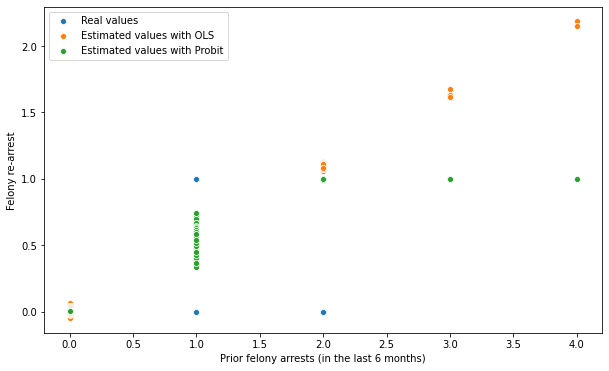

In [199]:
plt.figure(figsize=(10,6))
sns.scatterplot(data_eval['fel_6m'],data_eval['re_arrest'], label='Real values')
sns.scatterplot(data_eval['fel_6m'],model1.fittedvalues, label='Estimated values with OLS')
sns.scatterplot(data_eval['fel_6m'],probitm.predict(all_), label='Estimated values with Probit')
plt.xlabel("Prior felony arrests (in the last 6 months)")
plt.ylabel("Felony re-arrest")
plt.show()

*The results show no evidence of the program being succesful in reducing felony re-arrest in a 12-month follow-up. Adittionally, these results may be robust given that we have set several control variables such as age, gender, past arrests and also, assuming that the RCT was done correctly (we could verify this with balance tests).*